## Load and Create Dataset

In [ ]:
pip install google-cloud-bigquery

In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [1]:


# Setup Google Cloud BigQuery API

# Replace with your own key path
key_path = "/Users/theodoreleeiv/Documents/Documents - Theodore’s MacBook Pro/Google Cloud/inbound-density-428819-p8-aef577a5f38e.json"
credentials = service_account.Credentials.from_service_account_file(key_path)

client = bigquery.Client()


def QUERY(query):
    """
    Queries BigQuery
    :param query: string
    :return: dataframe
    """
    query = str(query)
    query_job = client.query(query)
    return query_job.result().to_dataframe()

In [8]:
df = QUERY("""
  SELECT
    r.subject_id,
    r.stay_id,
    r.hadm_id,
    r.readmit_stay_id,
    EXTRACT(DAY FROM edadmitdate) AS admit_day,
    EXTRACT(MONTH FROM edadmitdate) AS admit_month,
    EXTRACT(YEAR FROM edadmitdate) AS admit_year,
    EXTRACT(DAY FROM eddischargedate) AS discharge_day,
    EXTRACT(MONTH FROM edadmitdate) AS discharge_month,
    EXTRACT(YEAR FROM edadmitdate) AS discharge_year,
    edadmithour,
    eddischargehour,
    LOS_hr,
    days_to_readmission,
    had_readmission_within_30,
    is_readmission,
    arrival_transport,
    disposition,
    gender,
    anchor_age,
    insurance,
    marital_status,
    language,
    age_group,
    race,
    race_group,
    dod,
    temperature,
    heartrate,
    resprate,
    o2sat,
    sbp,
    dbp,
    acuity,
    m.name,
    CASE
    WHEN mental_health_category = "Substance-Related Mental Disorders" THEN 1
    ELSE 0
  END AS substance_related_disorder
  

FROM
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p

ON r.subject_id = p.subject_id

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d
ON
  r.stay_id = d.stay_id
  
LEFT JOIN
    `physionet-data.mimiciv_ed.triage` AS t
ON 
    r.stay_id = t.stay_id
LEFT JOIN 
    `physionet-data.mimiciv_ed.medrecon` AS m
ON  
    r.stay_id = m.stay_id
  
WHERE d.is_mh_disorder = 1

""")

In [9]:
df.head()

,subject_id,stay_id,hadm_id,readmit_stay_id,admit_day,admit_month,admit_year,discharge_day,discharge_month,discharge_year,...,dod,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,name,substance_related_disorder
0,12323018,31901271,25423956,<NA>,13,11,2153,15,11,2153,...,NaT,98.000000000,73.000000000,16.000000000,100.000000000,105.000000000,60.000000000,3.000000000,None,0
1,12323018,31901271,25423956,<NA>,13,11,2153,15,11,2153,...,NaT,98.000000000,73.000000000,16.000000000,100.000000000,105.000000000,60.000000000,3.000000000,None,0
2,13398738,30783374,<NA>,<NA>,7,7,2172,8,7,2172,...,NaT,98.200000000,114.000000000,16.000000000,98.000000000,132.000000000,99.000000000,2.000000000,iron,0
3,13398738,30783374,<NA>,<NA>,7,7,2172,8,7,2172,...,NaT,98.200000000,114.000000000,16.000000000,98.000000000,132.000000000,99.000000000,2.000000000,Zoloft,0
4,13398738,30783374,<NA>,<NA>,7,7,2172,8,7,2172,...,NaT,98.200000000,114.000000000,16.000000000,98.000000000,132.000000000,99.000000000,2.000000000,iron,0


### Check for NaNs

In [10]:
df.isnull().sum()

subject_id                         0
stay_id                            0
hadm_id                       126506
readmit_stay_id               214049
admit_day                          0
admit_month                        0
admit_year                         0
discharge_day                      0
discharge_month                    0
discharge_year                     0
edadmithour                        0
eddischargehour                    0
LOS_hr                             0
days_to_readmission           214049
had_readmission_within_30          0
is_readmission                     0
arrival_transport                  0
disposition                        0
gender                             0
anchor_age                        16
insurance                      45115
marital_status                 19097
language                       15140
age_group                          0
race                               0
dod                           314657
temperature                    14834
h

There is quite of bit of NaNs in the data. However, some NaNs are expected in hadm_id, not all patients have an associated hadm_id or readmit_stay_id, days_to_readmission, name (medication name), dod.

In [29]:
df['days_to_readmission'].fillna(0, inplace=True)
df['anchor_age'].fillna(np.round(df['anchor_age'].mean(),0), inplace=True)
df['temperature'].fillna(df['temperature'].mean(), inplace=True)
df['heartrate'].fillna(df['heartrate'].mean(), inplace=True)
df['resprate'].fillna(df['resprate'].mean(), inplace=True)
df['o2sat'].fillna(df['o2sat'].mean(), inplace=True)
df['sbp'].fillna(df['sbp'].mean(), inplace=True)
df['dbp'].fillna(df['dbp'].mean(), inplace=True)
df['acuity'].fillna(df['acuity'].mean(), inplace=True)

/var/folders/dl/r49548rn2gzfpg1c87vrjnvw0000gn/T/ipykernel_46653/2409924627.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['temperature'].fillna(df['temperature'].mean(), inplace=True)
/var/folders/dl/r49548rn2gzfpg1c87vrjnvw0000gn/T/ipykernel_46653/2409924627.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are set

In [30]:
df.isnull().sum()

subject_id                         0
stay_id                            0
hadm_id                       100362
readmit_stay_id               158759
admit_day                          0
admit_month                        0
admit_year                         0
discharge_day                      0
discharge_month                    0
discharge_year                     0
edadmithour                        0
eddischargehour                    0
LOS_hr                             0
days_to_readmission                0
had_readmission_within_30          0
is_readmission                     0
arrival_transport                  0
disposition                        0
gender                             0
anchor_age                         0
insurance                      35609
marital_status                 14890
language                       11652
age_group                          0
race                               0
dod                           239682
temperature                        0
h

### Drop Duplicates

In [11]:
df.drop_duplicates(inplace=True)

### Clean Columns

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 310229 entries, 0 to 403673
Data columns (total 35 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   subject_id                  310229 non-null  Int64  
 1   stay_id                     310229 non-null  Int64  
 2   hadm_id                     209867 non-null  Int64  
 3   readmit_stay_id             151470 non-null  Int64  
 4   admit_day                   310229 non-null  Int64  
 5   admit_month                 310229 non-null  Int64  
 6   admit_year                  310229 non-null  Int64  
 7   discharge_day               310229 non-null  Int64  
 8   discharge_month             310229 non-null  Int64  
 9   discharge_year              310229 non-null  Int64  
 10  edadmithour                 310229 non-null  Int64  
 11  eddischargehour             310229 non-null  Int64  
 12  LOS_hr                      310229 non-null  Int64  
 13  days_to_readmission

In [15]:
# Change gender column to a binary
df['gender'] = df['gender'].map({'F':0,'M':1})

In [16]:
# change the dtype of temperature, heartrate, reprate,o2sat, sbp, dbp, pain, and acuity to float values
def F(x):
    if x <= 38:
        C = x
        return (C * 9/5) + 32
    else:
        return x
df['temperature'] = df['temperature'].astype(float)
df['temperature'].apply(lambda x: F(x))
df['heartrate'] = df['heartrate'].astype(float)
df['resprate'] = df['resprate'].astype(float)
df['o2sat'] = df['o2sat'].astype(float)
df['sbp'] = df['sbp'].astype(float)
df['dbp'] = df['dbp'].astype(float)
df['acuity'] = df['acuity'].astype(float)

### identify Outliers

In [32]:
df.describe()

,subject_id,stay_id,hadm_id,readmit_stay_id,admit_day,admit_month,admit_year,discharge_day,discharge_month,discharge_year,...,gender,anchor_age,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,substance_related_disorder
count,310229.0,310229.0,209867.0,151470.0,310229.0,310229.0,310229.0,310229.0,310229.0,310229.0,...,310229.000000,310229.0,310229.00000,310229.000000,310229.000000,310229.000000,310229.000000,310229.000000,310229.000000,310229.0
mean,15048201.553253,35065427.733458,25029953.786393,35081513.000779,15.480787,6.6372,2159.035232,15.584268,6.6372,2159.035232,...,0.601153,45.656886,97.92134,89.500495,17.363228,98.300442,133.500452,82.232508,2.479498,0.453862
std,2611961.562933,2880811.994012,2878358.962107,2889129.866771,8.768046,3.479438,24.737276,8.769821,3.479438,24.737276,...,0.489662,14.279343,7.09424,16.880617,2.118367,16.030620,20.804314,73.810245,0.603696,0.497867
min,10000507.0,30000017.0,20000200.0,30000017.0,1.0,1.0,2110.0,1.0,1.0,2110.0,...,0.000000,18.0,6.80000,14.000000,1.000000,0.000000,1.000000,7.000000,1.000000,0.0
25%,13050816.0,32589714.0,22525788.0,32613679.0,8.0,4.0,2139.0,8.0,4.0,2139.0,...,0.000000,35.0,97.50000,78.000000,16.000000,97.000000,120.000000,71.000000,2.000000,0.0
50%,15302549.0,35105277.0,25052308.0,35142226.0,15.0,7.0,2161.0,16.0,7.0,2161.0,...,1.000000,47.0,98.00000,89.000000,18.000000,98.000000,133.000000,80.000000,2.000000,0.0
75%,17123250.0,37568988.0,27489717.0,37574202.0,23.0,10.0,2179.0,23.0,10.0,2179.0,...,1.000000,56.0,98.40000,100.000000,18.000000,100.000000,145.000000,89.000000,3.000000,1.0
max,19999466.0,39999964.0,29999277.0,39999964.0,31.0,12.0,2211.0,31.0,12.0,2211.0,...,1.000000,91.0,977.00000,922.000000,104.000000,1000.000000,776.000000,9110.000000,5.000000,1.0


- There are outliers in just about every column. So, I'll have to handle these outliers because they mess up correlations

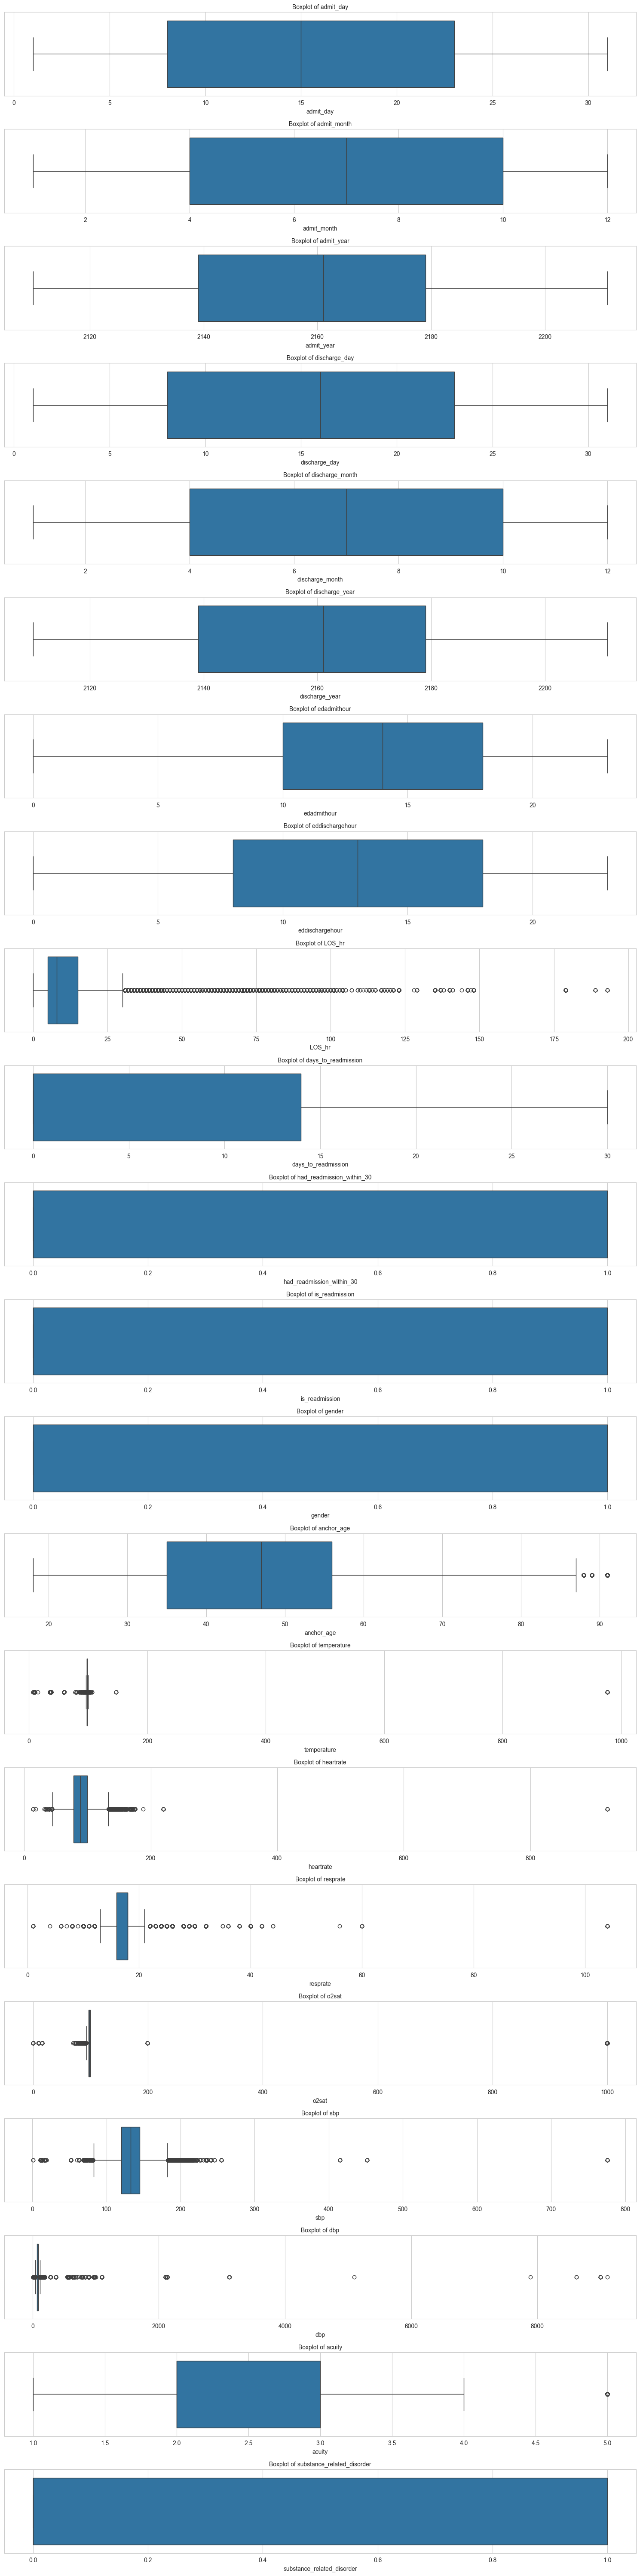

In [37]:
# Create Boxplots to identify Outliers
# Filter numeric columns
numeric_cols = df.drop(['subject_id','stay_id','hadm_id','readmit_stay_id'],axis=1).select_dtypes(include=['int64', 'Int64', 'float64']).columns

# Set up the plot grid
plt.figure(figsize=(15, 60))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}', fontsize=10)
    plt.tight_layout()

plt.show()

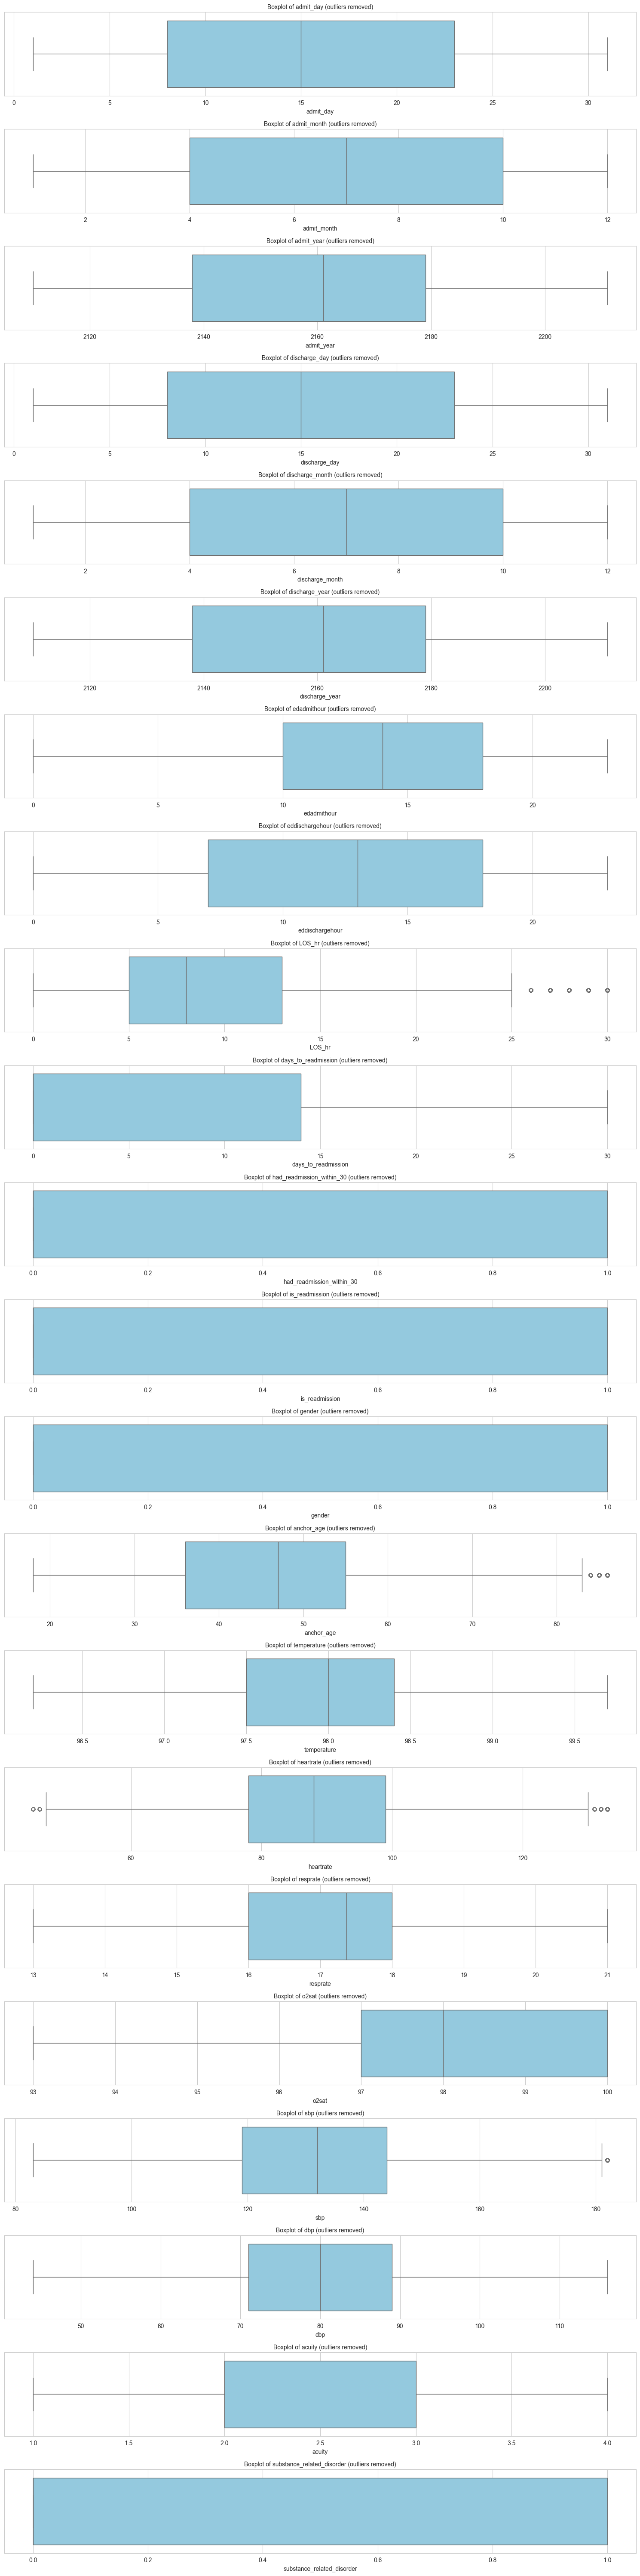

In [38]:
# use basic IQR method to remove outliers
df_cleaned = df.copy()
# Apply IQR filtering
for col in numeric_cols:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]

# Plot boxplots for the cleaned data
plt.figure(figsize=(15, 60))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.boxplot(x=df_cleaned[col], color='skyblue')
    plt.title(f'Boxplot of {col} (outliers removed)', fontsize=10)
    plt.tight_layout()

plt.show()

### Correlation Analysis

<Axes: >

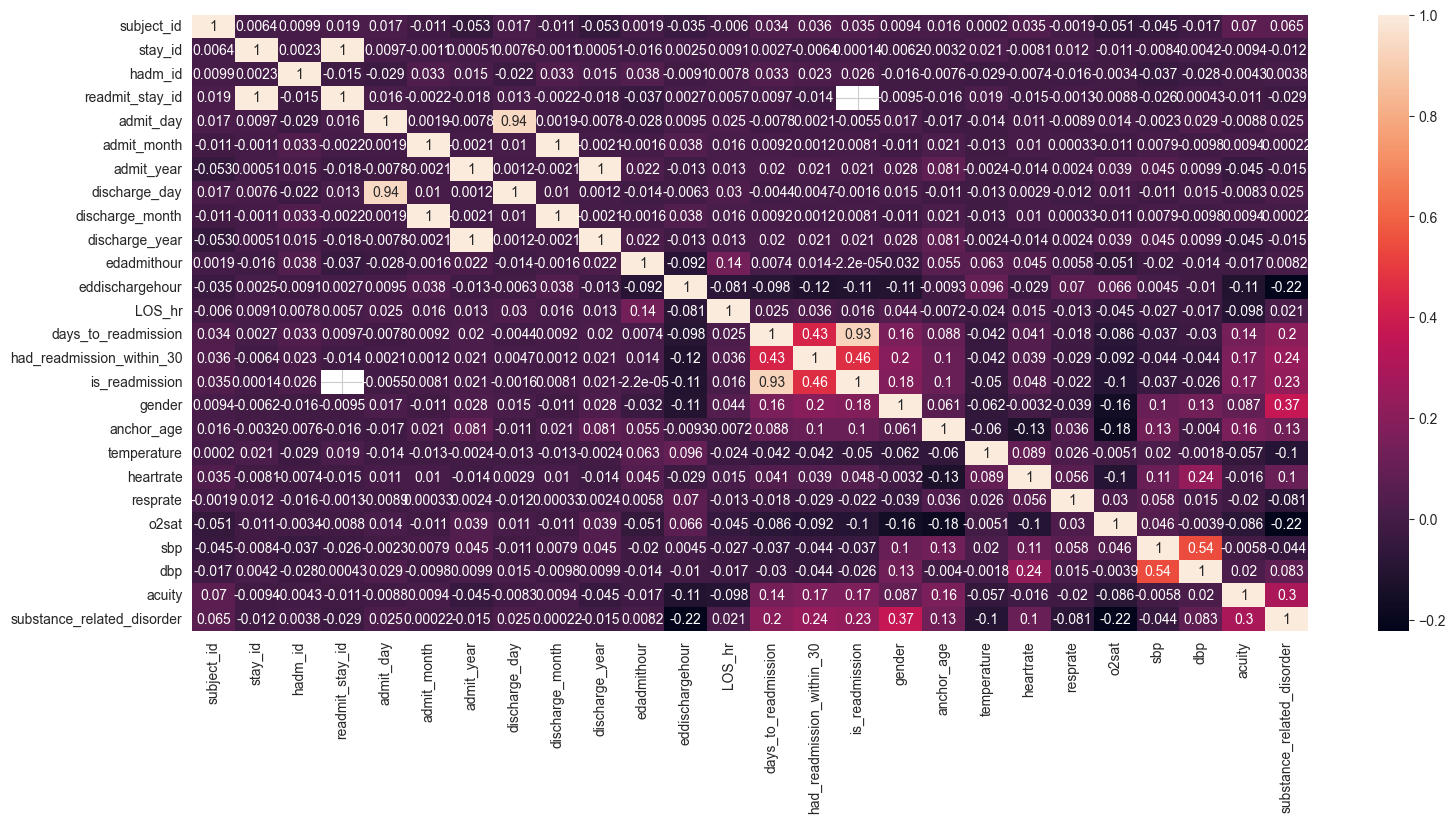

In [39]:
corr = df_cleaned.corr(method='spearman',numeric_only=True)
plt.figure(figsize=(18,8))
sns.heatmap(corr,annot=True)

In [57]:
categorical_cols = df.drop(['subject_id','stay_id','hadm_id','readmit_stay_id'],axis=1).select_dtypes(include=['object'])

In [58]:
categorical_cols.nunique()

arrival_transport       5
disposition             8
insurance               5
marital_status          4
language               25
age_group              10
race                   33
name                 4777
dtype: int64

In [55]:


onehot_categories = pd.get_dummies(categorical_cols,dtype='Int64',drop_first=True)

In [56]:
onehot_categories.head()

,arrival_transport_AMBULANCE,arrival_transport_HELICOPTER,arrival_transport_OTHER,arrival_transport_UNKNOWN,arrival_transport_WALK IN,disposition_ADMITTED,disposition_ELOPED,disposition_EXPIRED,disposition_HOME,disposition_LEFT AGAINST MEDICAL ADVICE,...,name_ziprasidone HCl [Geodon],name_zoledronic acid-mannitol-water [Reclast],name_zolmitriptan,name_zolmitriptan [Zomig],name_zolpidem,name_zolpidem [Ambien CR],name_zolpidem [Ambien],name_zonisamide,name_zonisamide [Zonegran],name_zoster vaccine live (PF) [ZOSTAVAX (PF)]
0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
